<a href="https://colab.research.google.com/github/young-hyun-park/HW/blob/main/2d_liver_segmentation_using_smp_39%EB%AA%85%EC%9D%BC%EB%B0%98%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 6.1 MB/s 
     |████████████████████████████████| 376 kB 66.2 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d82866a7b3754a4316582cd7b9463545d0bd9fa23fe8837e69b42816ba6bfaf5
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2ce55f2075875c113597187c374c3a30826b82fefd7067fa65c0dddd04b27021
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import cv2 
import nibabel as nib
import segmentation_models_pytorch as smp
import tarfile

In [3]:
seed = 1

lr = 0.001
momentum = 0.99

batch_size = 8
test_batch_size = 8

epochs = 10
log_interval = 10

# Load Data path

In [4]:
PATH = '/content/drive/MyDrive/Task03_Liver/Task03_Liver'

In [5]:
image_path =os.path.join(PATH+'/Task03_Liver.tar')

In [6]:
file=tarfile.open(image_path)
file.extractall('/content')
file.close()

In [7]:
image_path_list = glob('/content/image'+'/*')
mask_path_list = glob('/content/mask'+'/*')

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_path,test_path = train_test_split(image_path_list, test_size = 0.1, random_state = 42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
t_list = list()
for path in train_path:
  train_file = path.split('/')[-1]
  train_mask = '/content/mask'+ '/'+train_file
  mask_list = glob(train_mask+'/*.png')
  for mask_path in mask_list:
    t_list.append('/content/image'+'/'+train_file+'/'+mask_path.split('/')[-1])

In [10]:
train_image_path = list()
dummy_mask_path = list()
non_mask_path = list()
i=0
a = np.random.randint(117, size = round(len(train_path)/3))
for path in train_path:
  train_file = path.split('/')[-1]
  train_mask = '/content/mask'+ '/'+train_file
  mask_list = glob(train_mask+'/*.png')
  if np.sum(a==i) > 0:
    for mask_path in mask_list:
      train_image_path.append('/content/image'+'/'+train_file+'/'+mask_path.split('/')[-1])
  else: 
    for mask_path in mask_list:
      mask_ = np.array(Image.open(mask_path))
      dummy_mask_path.append(mask_path)
      if np.sum(mask_) > 0:
        train_image_path.append('/content/image'+'/'+train_file+'/'+mask_path.split('/')[-1])
      else:
        pass
  i+=1

In [11]:
train_image_path[15000]

'/content/image/liver_90/liver_90_570.png'

In [12]:
test_image_path = list()
for i in test_path:
  test_image_path_ = glob(i +'/*.png')
  for path in test_image_path_:
    test_image_path.append(path)

In [13]:
'''
train_image_path = list()
test_image_path = list()
for i in train_path:
  train_image_path_ = glob(i+'/*.png')
  for path in train_image_path_:
    train_image_path.append(path)
for i in test_path:
  test_image_path_ = glob(i +'/*.png')
  for path in train_image_path_:
    test_image_path.append(path)
    '''

"\ntrain_image_path = list()\ntest_image_path = list()\nfor i in train_path:\n  train_image_path_ = glob(i+'/*.png')\n  for path in train_image_path_:\n    train_image_path.append(path)\nfor i in test_path:\n  test_image_path_ = glob(i +'/*.png')\n  for path in train_image_path_:\n    test_image_path.append(path)\n    "

In [14]:
image = Image.open(train_image_path[0])
image = np.array(image)
image.shape

(512, 512)

# Dataset

In [64]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img_name = path.split('/')[-1]
        file_name = path.split('/')[-2]
        one_mask_path =  '/content/mask'+ '/' + file_name + '/'+ img_name
        image = np.array(Image.open(path).resize((256,256)))
        image = image[:,:,np.newaxis]/255
        mask =  np.array(Image.open(one_mask_path).resize((256,256)))
        mask = mask[:,:,np.newaxis]
        mask[mask > 1] = 1
        mask = cv2.rotate(mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image.type(torch.FloatTensor), mask.type(torch.FloatTensor)

In [65]:
class Test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img_name = path.split('/')[-1]
        file_name = path.split('/')[-2]
        one_mask_path = '/content/mask' + '/' + file_name + '/'+img_name
        image = np.array(Image.open(path).resize((256,256)))
        image = image[:,:,np.newaxis]/255
        mask =  np.array(Image.open(one_mask_path).resize((256,256)))
        mask = mask[:,:,np.newaxis]
        mask[mask > 1] = 1
        mask = cv2.rotate(mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image.type(torch.FloatTensor) , mask.type(torch.FloatTensor)

In [66]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo    
import albumentations as A                                                             
from albumentations.pytorch import ToTensorV2
train_transform = A.Compose(
    [
      ToTensorV2(transpose_mask=True)
     ]
    )

test_transform = A.Compose([
     ToTensorV2(transpose_mask=True)
                            ]
                           )

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-zexptih7



In [67]:
train_data = Train_Dataset(train_image_path,transform = train_transform)
test_data = Test_Dataset(test_image_path,transform = test_transform)

In [68]:
'''
a = np.random.randint(10000, size = 5)
plt.figure(figsize = (20,40))
k=0
for i in a:
    k+=2
    plt.subplot(5,2,k-1)
    image = np.array(Image.open(train_image_path[i]))
    print(image)
    plt.imshow(image, 'gray')
    plt.subplot(5,2,k)
    img_name = train_image_path[i].split('/')[-1]
    file_name = train_image_path[i].split('/')[-2]
    one_mask_path =  '/content/mask'+ '/' + file_name + '/'+ img_name
    mask = np.array(Image.open(one_mask_path))
    print(np.unique(mask))
    plt.imshow(mask,'gray')
    '''

"\na = np.random.randint(10000, size = 5)\nplt.figure(figsize = (20,40))\nk=0\nfor i in a:\n    k+=2\n    plt.subplot(5,2,k-1)\n    image = np.array(Image.open(train_image_path[i]))\n    print(image)\n    plt.imshow(image, 'gray')\n    plt.subplot(5,2,k)\n    img_name = train_image_path[i].split('/')[-1]\n    file_name = train_image_path[i].split('/')[-2]\n    one_mask_path =  '/content/mask'+ '/' + file_name + '/'+ img_name\n    mask = np.array(Image.open(one_mask_path))\n    print(np.unique(mask))\n    plt.imshow(mask,'gray')\n    "

In [69]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
        batch_size = batch_size,
    shuffle = False,
)

# Model

In [70]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [71]:
save_path = "/content/drive/MyDrive/Task03_Liver/Task03_Liver"
###############################
trial = 1
n_epoches = 100
LR = 0.001
LR_DECREASE = 1e-5
lr_decrease_epoch = 10
BATCH_SIZE = 64
patience= 20
###############################
ENCODER = 'resnet34'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation=ACTIVATION,
)

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

In [72]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [73]:
max_score = 0
early_stopping = EarlyStopping(patience=patience, verbose=True)
train_loss = list()
train_iou = list()
test_loss = list()
test_iou = list()
for epoch in range(0, n_epoches):
    print(f'\nEpoch: {epoch}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = val_epoch.run(test_loader)
    
    with open(os.path.join(save_path, f'results{str(trial).zfill(2)}.csv'), 'a') as f:
            f.write('%03d,%0.6f,%0.6f,%0.6f,%0.6f\n' % (
                (epoch + 1),
                train_logs['dice_loss'],
                train_logs['iou_score'],
                valid_logs['dice_loss'],
                valid_logs['iou_score'],
            ))
    train_loss.append(train_logs['dice_loss'])
    train_iou.append(train_logs['iou_score'])
    test_loss.append(valid_logs['dice_loss'])
    test_iou.append(valid_logs['iou_score'])
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(save_path, f'best_model{str(trial).zfill(2)}.pth'))
        print('New Record!')
        
    torch.save(model, os.path.join(save_path, f'final_model{str(trial).zfill(2)}.pth'))
    
    early_stopping(valid_logs['dice_loss'], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    if epoch == lr_decrease_epoch:
        optimizer.param_groups[0]['lr'] = LR_DECREASE
        print(f'Decrease decoder learning rate to {LR_DECREASE}!')


Epoch: 0
train:   1%|          | 30/3126 [00:07<12:23,  4.16it/s, dice_loss - -0.6016, iou_score - 0.03734]


KeyboardInterrupt: ignored

In [ ]:
for batch_idx, data in enumerate(train_loader):
  image = np.squeeze(data[0].cpu().data.numpy())
  mask = np.squeeze(data[1].cpu().data.numpy())
  break

In [ ]:
plt.subplot(2,1,1)
plt.imshow(image[4],'gray')
plt.subplot(2,1,2)
plt.imshow(mask[4],'gray')

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('U-Net Model Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,0.8)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(train_iou)
plt.plot(test_iou)
plt.title('U-Net Model IOU', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('IOU', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [38]:
best_model = torch.load('/content/drive/MyDrive/Task03_Liver/Task03_Liver/best_model01.pth')

In [ ]:
from torchsummary import summary
summary(best_model, (1,128,128))

In [ ]:

from torch.utils.data import Dataset:
  sample_path = train_image_path[0]
  sample_image = np.array(Image.open(sample_path).resize((256,256)))
  sample_image = torch.from_numpy(sample_image).to('cuda')
  pred_mask = best_model.predict(sample_image)

In [40]:
device = 'cuda'
from cv2 import imwrite

In [41]:
with torch.no_grad():
  for data in test_loader:
          inputs = data[0]
          inputs_test = inputs.to(device = device,dtype = torch.float32)
          masks = data[1]
          labels_test = masks.to(device = device,dtype = torch.float32)
          test_masks_pred = best_model(inputs_test)

KeyboardInterrupt: ignored

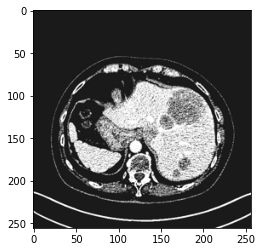

In [61]:
plt.imshow(np.squeeze(inputs[2].cpu().data.numpy()),'gray')

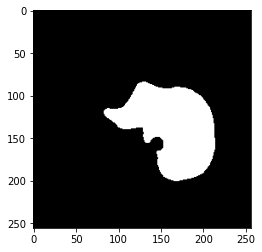

In [62]:
plt.imshow(np.squeeze(masks[2].cpu().data.numpy()),'gray')

In [63]:
np.unique(masks[2].cpu().data.numpy())

array([0., 1.], dtype=float32)

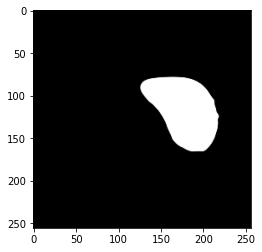

In [55]:
plt.imshow(np.squeeze(test_masks_pred[0].cpu().data.numpy()),'gray')

In [ ]:
pred_path = glob(save_path+'/predict_mask/*.png')

In [ ]:
len(pred_path)

In [ ]:
a = np.random.randint(7732, size = 5)
plt.figure(figsize = (20,40))
k=0
for i in a:
    k+=3
    plt.subplot(5,3,k-2)
    image_name = pred_path[i].split('/')[-1]
    image_file = image_name.split('_')[0]+'_'+image_name.split('_')[1]
    image_paths = '/content/image/'+image_file+'/'+image_name
    image = np.array(Image.open(image_paths).resize((256,256)))
    plt.imshow(image, 'gray')
    plt.title('Image')
    plt.subplot(5,3,k-1)
    one_mask_path =  '/content/mask'+ '/' + image_file + '/'+ image_name
    mask = np.array(Image.open(one_mask_path).resize((256,256)))
    mask = cv2.rotate(mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
    mask[mask==2]=1
    plt.imshow(mask,'gray')
    plt.title('Mask')
    plt.subplot(5,3,k)
    pred_mask = np.array(Image.open(pred_path[i]))
    plt.imshow(pred_mask,'gray')
    plt.title('Prediction')